# Домашнее задание. Классификация изображений



Сегодня вам предстоить помочь телекомпании FOX в обработке их контента. Как вы знаете, сериал "Симпсоны" идет на телеэкранах более 25 лет, и за это время скопилось очень много видеоматериала. Персоонажи менялись вместе с изменяющимися графическими технологиями, и Гомер Симпсон-2018 не очень похож на Гомера Симпсона-1989. В этом задании вам необходимо классифицировать персонажей, проживающих в Спрингфилде. Думаю, нет смысла представлять каждого из них в отдельности.




In [3]:
#Анна_Мацкевич_421676042. Итоговая оценка на кагле 0.99...

Краткий пересказ моего решения:
    В функции fit_epoch пропущен model.train() это добавила, до этого было много разных моделей, который выше 0.8 не набирали. После замены resnet18 без заморозки слоев набрала сразу на kaggle 0.99
    
    

### Установка зависимостей

In [1]:
# we will verify that GPU is enabled for this notebook

# following should print: CUDA is available!  Training on GPU ...

#

# if it prints otherwise, then you need to enable GPU:

# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU



import torch

import numpy as np



train_on_gpu = torch.cuda.is_available()



if not train_on_gpu:

    print('CUDA is not available.  Training on CPU ...')

else:

    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [2]:
import PIL

print(PIL.__version__)

10.4.0


In [4]:
!nvidia-smi

import torch

torch.cuda.is_available()

Wed Nov 20 19:53:13 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   35C    P8              9W /   70W |       3MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

True

В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [5]:
import pickle

import numpy as np

from skimage import io



from tqdm import tqdm, tqdm_notebook

from PIL import Image

from pathlib import Path



from torchvision import transforms

from multiprocessing.pool import ThreadPool

from sklearn.preprocessing import LabelEncoder

from torch.utils.data import Dataset, DataLoader

import torch.nn as nn



from matplotlib import colors, pyplot as plt

%matplotlib inline



# в sklearn не все гладко, чтобы в colab удобно выводить картинки

# мы будем игнорировать warnings

import warnings

warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [6]:


# разные режимы датасета

DATA_MODES = ['train', 'val', 'test']

# все изображения будут масштабированы к размеру 224x224 px

RESCALE_SIZE = 224

# работаем на видеокарте

DEVICE = torch.device("cuda")

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation.



ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:

$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet





Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.

 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample)

In [33]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [8]:
def imshow(inp, title=None, plt_ax=plt, default=False):

    """Imshow для тензоров"""

    inp = inp.numpy().transpose((1, 2, 0))

    mean = np.array([0.485, 0.456, 0.406])

    std = np.array([0.229, 0.224, 0.225])

    inp = std * inp + mean

    inp = np.clip(inp, 0, 1)

    plt_ax.imshow(inp)

    if title is not None:

        plt_ax.set_title(title)

    plt_ax.grid(False)

In [9]:
#определим директории с тренировочными и тестовыми файлами

TRAIN_DIR = Path('/kaggle/input/journey-springfield/train/simpsons_dataset')
TEST_DIR = Path('/kaggle/input/journey-springfield/testset')

In [10]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))

test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [11]:
from sklearn.model_selection import train_test_split



train_val_labels = [path.parent.name for path in train_val_files]

train_files, val_files = train_test_split(train_val_files, test_size=0.25, \

                                          stratify=train_val_labels)

In [12]:
val_dataset = SimpsonsDataset(val_files, mode='val')

In [13]:
# uncomment if you have problem with pillow

# def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()

# Image.register_extension = register_extension

# def register_extensions(id, extensions):

#     for extension in extensions: register_extension(id, extension)

# Image.register_extensions = register_extensions

Давайте посмотрим на наших героев внутри датасета.

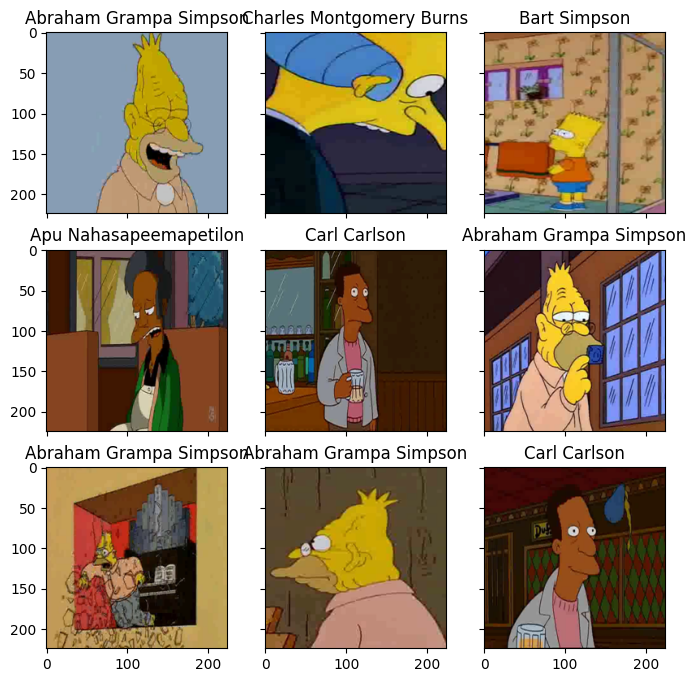

In [14]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \

                        sharey=True, sharex=True)

for fig_x in ax.flatten():

    random_characters = int(np.random.uniform(0,1000))

    im_val, label = val_dataset[random_characters]

    img_label = " ".join(map(lambda x: x.capitalize(),\

                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))

    imshow(im_val.data.cpu(), \

          title=img_label,plt_ax=fig_x)

Можете добавить ваши любимые сцены и классифицировать их. (веселые результаты можно кидать в чат)

### Построение нейросети



Запустить данную сеть будет вашим мини-заданием на первую неделю, чтобы было проще участвовать в соревновании.



Данная архитектура будет очень простой и нужна для того, чтобы установить базовое понимание и получить простенький сабмит на Kaggle



<!-- Здесь вам предлагается дописать сверточную сеть глубины 4/5.  -->



*Описание слоев*:







1. размерность входа: 3x224x224

2.размерности после слоя:  8x111x111

3. 16x54x54

4. 32x26x26

5. 64x12x12

6. выход: 96x5x5


In [37]:
# Очень простая сеть

class SimpleCnn(nn.Module):



    def __init__(self, n_classes):

        super().__init__()

        self.conv1 = nn.Sequential(

            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),

            nn.ReLU(),

            nn.MaxPool2d(kernel_size=2)

        )

        self.conv2 = nn.Sequential(

            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),

            nn.ReLU(),

            nn.MaxPool2d(kernel_size=2)

        )

        self.conv3 = nn.Sequential(

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),

            nn.ReLU(),

            nn.MaxPool2d(kernel_size=2)

        )

        self.conv4 = nn.Sequential(

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),

            nn.ReLU(),

            nn.MaxPool2d(kernel_size=2)

        )

        self.conv5 = nn.Sequential(

            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),

            nn.ReLU(),

            nn.MaxPool2d(kernel_size=2)

        )



        self.out = nn.Linear(96 * 5 * 5, n_classes)





    def forward(self, x):

        x = self.conv1(x)

        x = self.conv2(x)

        x = self.conv3(x)

        x = self.conv4(x)

        x = self.conv5(x)



        x = x.view(x.size(0), -1)

        logits = self.out(x)

        return logits

In [38]:
def fit_epoch(model, train_loader, criterion, optimizer):

    model.train()

    running_loss = 0.0

    running_corrects = 0

    processed_data = 0



    for inputs, labels in train_loader:

        inputs = inputs.to(DEVICE)

        labels = labels.to(DEVICE)

        optimizer.zero_grad()



        outputs = model(inputs)

        loss = criterion(outputs, labels)

        loss.backward()

        optimizer.step()

        preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)

        running_corrects += torch.sum(preds == labels.data)

        processed_data += inputs.size(0)



    train_loss = running_loss / processed_data

    train_acc = running_corrects.cpu().numpy() / processed_data

    return train_loss, train_acc

In [17]:
def eval_epoch(model, val_loader, criterion):

    model.eval()

    running_loss = 0.0

    running_corrects = 0

    processed_size = 0



    for inputs, labels in val_loader:

        inputs = inputs.to(DEVICE)

        labels = labels.to(DEVICE)



        with torch.set_grad_enabled(False):

            outputs = model(inputs)

            loss = criterion(outputs, labels)

            preds = torch.argmax(outputs, 1)



        running_loss += loss.item() * inputs.size(0)

        running_corrects += torch.sum(preds == labels.data)

        processed_size += inputs.size(0)

    val_loss = running_loss / processed_size

    val_acc = running_corrects.double() / processed_size

    return val_loss, val_acc

In [18]:
def train(train_files, val_files, model, epochs, batch_size):

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)



    history = []

    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"



    with tqdm(desc="epoch", total=epochs) as pbar_outer:

        opt = torch.optim.Adam(model.parameters())

        criterion = nn.CrossEntropyLoss()



        for epoch in range(epochs):

            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)

            print("loss", train_loss)



            val_loss, val_acc = eval_epoch(model, val_loader, criterion)

            history.append((train_loss, train_acc, val_loss, val_acc))



            pbar_outer.update(1)

            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\

                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))



    return history

In [19]:
def predict(model, test_loader):

    with torch.no_grad():

        logits = []



        for inputs in test_loader:

            inputs = inputs.to(DEVICE)

            model.eval()

            outputs = model(inputs).cpu()

            logits.append(outputs)



    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()

    return probs

In [27]:
n_classes = len(np.unique(train_val_labels))

simple_cnn = SimpleCnn(n_classes).to(DEVICE)

print("we will classify :{}".format(n_classes))

print(simple_cnn)

we will classify :42
SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv5): Sequential(
    (0): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=2400, out_fea

Запустим обучение сети.

In [28]:
if val_dataset is None:

    val_dataset = SimpsonsDataset(val_files, mode='val')



train_dataset = SimpsonsDataset(train_files, mode='train')

In [29]:
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=2, batch_size=64)

epoch:   0%|          | 0/2 [00:00<?, ?it/s]

loss 2.461892077433652


epoch:  50%|█████     | 1/2 [03:37<03:37, 217.71s/it]


Epoch 001 train_loss: 2.4619 val_loss 1.8561 train_acc 0.3140 val_acc 0.5071
loss 1.4941074709443045


epoch: 100%|██████████| 2/2 [05:46<00:00, 173.27s/it]


Epoch 002 train_loss: 1.4941 val_loss 1.3704 train_acc 0.5888 val_acc 0.6305


Построим кривые обучения

In [30]:
loss, acc, val_loss, val_acc = zip(*history)

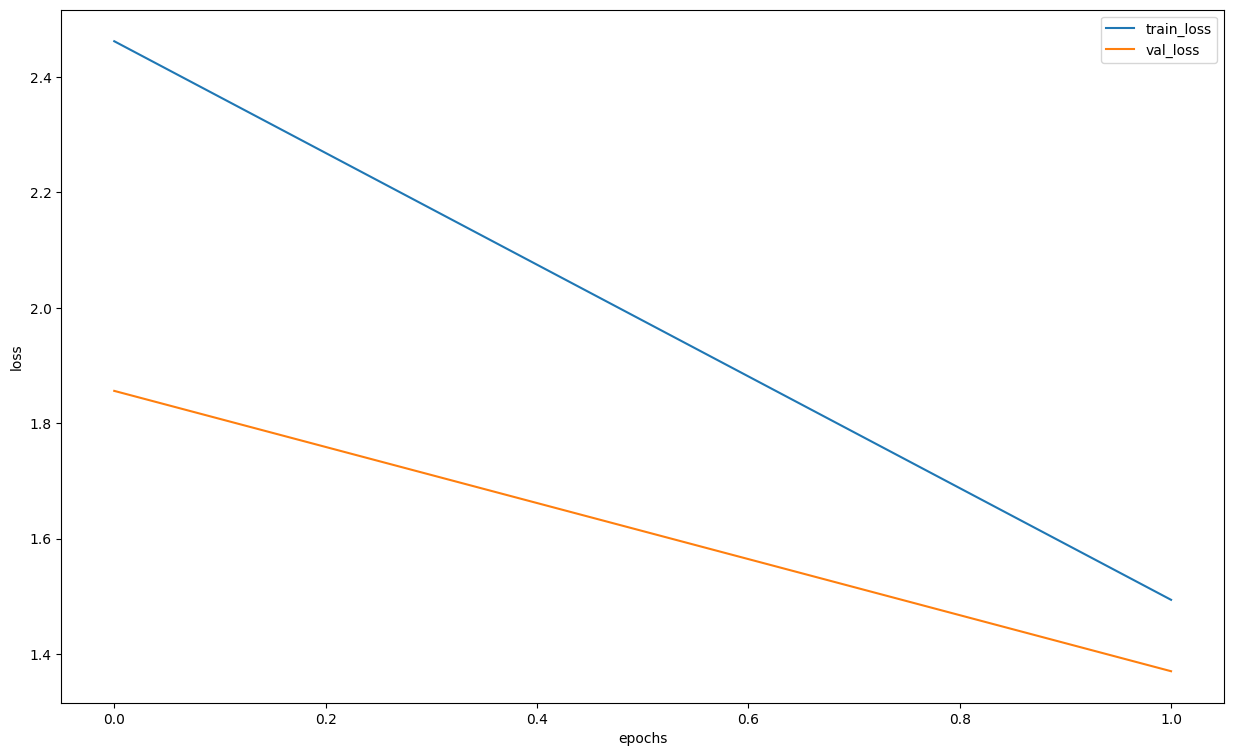

In [31]:
plt.figure(figsize=(15, 9))

plt.plot(loss, label="train_loss")

plt.plot(val_loss, label="val_loss")

plt.legend(loc='best')

plt.xlabel("epochs")

plt.ylabel("loss")

plt.show()

### Ну и что теперь со всем этим делать?

![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

Хорошо бы понять, как сделать сабмит.

У нас есть сеть и методы eval у нее, которые позволяют перевести сеть в режим предсказания. Стоит понимать, что у нашей модели на последнем слое стоит softmax, которые позволяет получить вектор вероятностей  того, что объект относится к тому или иному классу. Давайте воспользуемся этим.

In [53]:
def predict_one_sample(model, inputs, device=DEVICE):

    """Предсказание, для одной картинки"""

    with torch.no_grad():

        inputs = inputs.to(device)

        model.eval()

        logit = model(inputs).cpu()

        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()

    return probs

In [33]:
random_characters = int(np.random.uniform(0,1000))

ex_img, true_label = val_dataset[random_characters]

probs_im = predict_one_sample(simple_cnn, ex_img.unsqueeze(0))

In [34]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))

imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]



probs_ims = predict(simple_cnn, imgs)

In [35]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [36]:
y_pred = np.argmax(probs_ims,-1)



actual_labels = [val_dataset[id][1] for id in idxs]



preds_class = [label_encoder.classes_[i] for i in y_pred]

Обратите внимание, что метрика, которую необходимо оптимизировать в конкурсе --- f1-score. Вычислим целевую метрику на валидационной выборке.

In [37]:
from sklearn.metrics import f1_score

f1 = f1_score(actual_labels, y_pred, average='micro')



print("F1-оценка:", f1)


F1-оценка: 0.6


Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

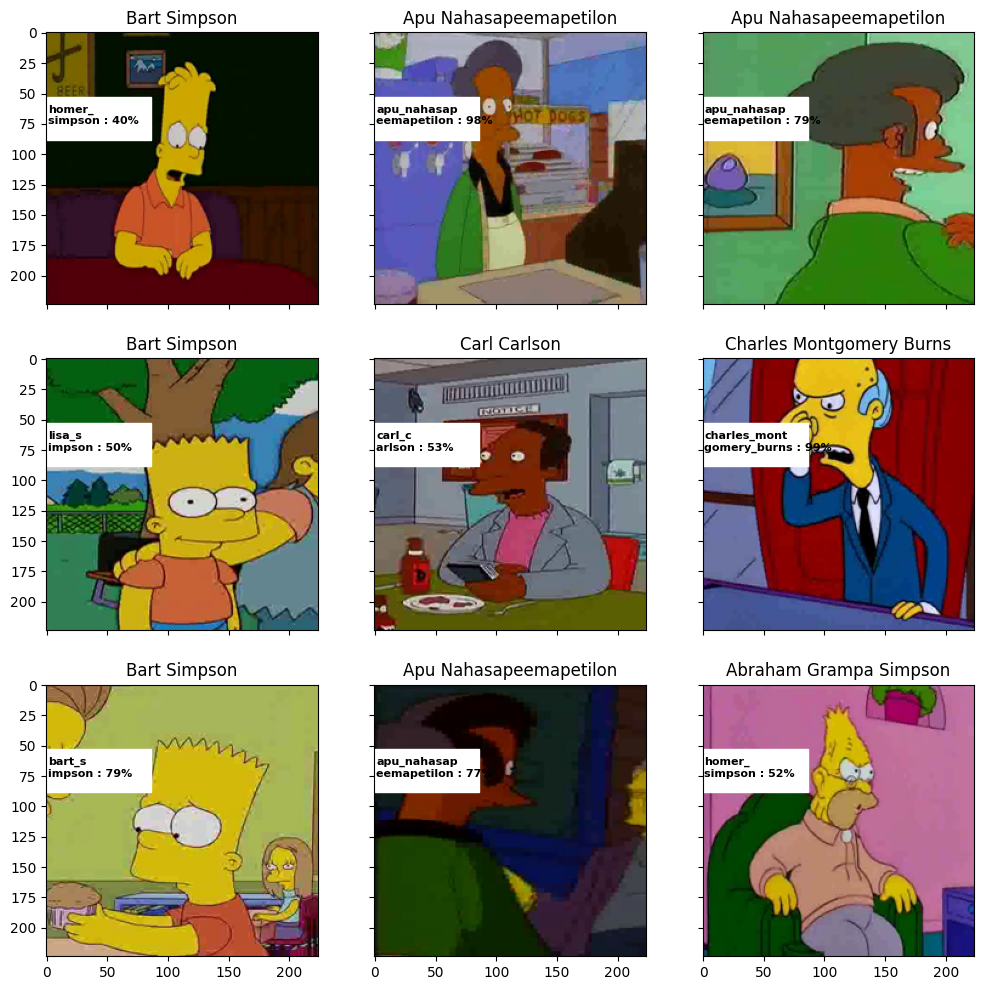

In [38]:
import matplotlib.patches as patches

from matplotlib.font_manager import FontProperties



fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \

                        sharey=True, sharex=True)

for fig_x in ax.flatten():

    random_characters = int(np.random.uniform(0,1000))

    im_val, label = val_dataset[random_characters]

    img_label = " ".join(map(lambda x: x.capitalize(),\

                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))







    imshow(im_val.data.cpu(), \

          title=img_label,plt_ax=fig_x)



    actual_text = "Actual : {}".format(img_label)



    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))

    font0 = FontProperties()

    font = font0.copy()

    font.set_family("fantasy")

    prob_pred = predict_one_sample(simple_cnn, im_val.unsqueeze(0))

    predicted_proba = np.max(prob_pred)*100

    y_pred = np.argmax(prob_pred)



    predicted_label = label_encoder.classes_[y_pred]

    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]

    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)



    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,

                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

Попробуйте найти те классы, которые сеть не смогла расспознать. Изучите данную проблему, это понадобится в дальнейшем.

### Submit на Kaggle

![alt text](https://i.redd.it/nuaphfioz0211.jpg)

In [39]:
test_dataset = SimpsonsDataset(test_files, mode="test")

test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)

probs = predict(simple_cnn, test_loader)





preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))

test_filenames = [path.name for path in test_dataset.files]


In [40]:
! ls

label_encoder.pkl


In [44]:
import pandas as pd

my_submit = pd.read_csv("/kaggle/input/journey-springfield/sample_submission.csv")

my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})

# my_submit["Expected"] = preds

my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [45]:
# TODO : сделайте сабмит (это важно, если Вы не справляетесь, но дошли до этой ячейки, то сообщите в чат и Вам помогут)

In [46]:
my_submit.to_csv('simple_cnn_baseline.csv', index=False)

## Приключение?



А теперь самое интересное, мы сделали простенькую сверточную сеть и смогли отправить сабмит, но получившийся скор нас явно не устраивает. Надо с этим что-то сделать.



Несколько срочныйх улучшейни для нашей сети, которые наверняка пришли Вам в голову:





*   Учим дольше и изменяем гиперпараметры сети

*  learning rate, batch size, нормализация картинки и вот это всё

*   Кто же так строит нейронные сети? А где пулинги и батч нормы? Надо добавлять

*  Ну разве Адам наше все? [adamW](https://www.fast.ai/2018/07/02/adam-weight-decay/) для практика, [статейка для любителей](https://openreview.net/pdf?id=ryQu7f-RZ) (очень хороший анализ), [наши ](https://github.com/MichaelKonobeev/adashift/) эксперименты для заинтересованных.



* Ну разве это deep learning? Вот ResNet и Inception, которые можно зафайнтьюнить под наши данные, вот это я понимаю (можно и обучить в колабе, а можно и [готовые](https://github.com/Cadene/pretrained-models.pytorch) скачать).



* Данных не очень много, можно их аугументировать и  доучититься на новом датасете ( который уже будет состоять из, как  пример аугументации, перевернутых изображений)



* Стоит подумать об ансамблях





Надеюсь, что у Вас получится!



![alt text](https://pbs.twimg.com/profile_images/798904974986113024/adcQiVdV.jpg)


Я начала с смены оптимизатора на AdamW, учеличения числа эпох и добавления нормализации

In [39]:


def train_with_opt(train_files, val_files, model, epochs, batch_size):

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)



    history = []

    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"



    with tqdm(desc="epoch", total=epochs) as pbar_outer:

        opt = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.01)

        criterion = nn.CrossEntropyLoss()



        for epoch in range(epochs):

            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)

            print("loss", train_loss)



            val_loss, val_acc = eval_epoch(model, val_loader, criterion)

            history.append((train_loss, train_acc, val_loss, val_acc))



            pbar_outer.update(1)

            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\

                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))



    return history

In [40]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))

test_files = sorted(list(TEST_DIR.rglob('*.jpg')))



from sklearn.model_selection import train_test_split



train_val_labels = [path.parent.name for path in train_val_files]

train_files, val_files = train_test_split(train_val_files, test_size=0.25, \

                                          stratify=train_val_labels)

val_dataset = SimpsonsDataset(val_files, mode='val')

In [1]:
class Not_Simple_My_Cnn(nn.Module):



    def __init__(self, n_classes):

        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.dropout = nn.Dropout(p=0.3)
        self.l1 = nn.Linear(256, 256)
        self.out = nn.Linear(256, n_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        logits = self.out(self.l1(x))
        return logits

NameError: name 'nn' is not defined

In [47]:
n_classes = len(np.unique(train_val_labels))

my_not_simple_cnn = Not_Simple_My_Cnn(n_classes).to(DEVICE)

print("we will classify :{}".format(n_classes))

print(my_not_simple_cnn)

we will classify :42
Not_Simple_My_Cnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

In [48]:
if val_dataset is None:

    val_dataset = SimpsonsDataset(val_files, mode='val')



train_dataset = SimpsonsDataset(train_files, mode='train')

In [50]:
history = train(train_dataset, val_dataset, model=my_not_simple_cnn, epochs=10, batch_size=64)

loss, acc, val_loss, val_acc = zip(*history)


epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 1.0231053423893681


epoch:  10%|█         | 1/10 [02:12<19:51, 132.42s/it]


Epoch 001 train_loss: 1.0231 val_loss 0.8984 train_acc 0.7154 val_acc 0.7491
loss 0.7617440020227836


epoch:  20%|██        | 2/10 [04:25<17:43, 132.93s/it]


Epoch 002 train_loss: 0.7617 val_loss 0.8572 train_acc 0.7833 val_acc 0.7684
loss 0.6259112592749295


epoch:  30%|███       | 3/10 [06:38<15:29, 132.83s/it]


Epoch 003 train_loss: 0.6259 val_loss 0.6771 train_acc 0.8211 val_acc 0.8162
loss 0.5105451455244753


epoch:  40%|████      | 4/10 [08:50<13:15, 132.53s/it]


Epoch 004 train_loss: 0.5105 val_loss 0.6341 train_acc 0.8499 val_acc 0.8345
loss 0.4320075538832106


epoch:  50%|█████     | 5/10 [11:02<11:02, 132.50s/it]


Epoch 005 train_loss: 0.4320 val_loss 0.6680 train_acc 0.8748 val_acc 0.8282
loss 0.34925552533647725


epoch:  60%|██████    | 6/10 [13:14<08:49, 132.29s/it]


Epoch 006 train_loss: 0.3493 val_loss 0.6230 train_acc 0.8966 val_acc 0.8439
loss 0.3121064208384813


epoch:  70%|███████   | 7/10 [15:24<06:33, 131.30s/it]


Epoch 007 train_loss: 0.3121 val_loss 0.5778 train_acc 0.9077 val_acc 0.8603
loss 0.2668997428984283


epoch:  80%|████████  | 8/10 [17:33<04:21, 130.65s/it]


Epoch 008 train_loss: 0.2669 val_loss 0.6013 train_acc 0.9155 val_acc 0.8582
loss 0.2500362991337503


epoch:  90%|█████████ | 9/10 [19:43<02:10, 130.61s/it]


Epoch 009 train_loss: 0.2500 val_loss 0.6547 train_acc 0.9214 val_acc 0.8563
loss 0.2162546165758762


epoch: 100%|██████████| 10/10 [21:55<00:00, 131.51s/it]


Epoch 010 train_loss: 0.2163 val_loss 0.6101 train_acc 0.9343 val_acc 0.8607


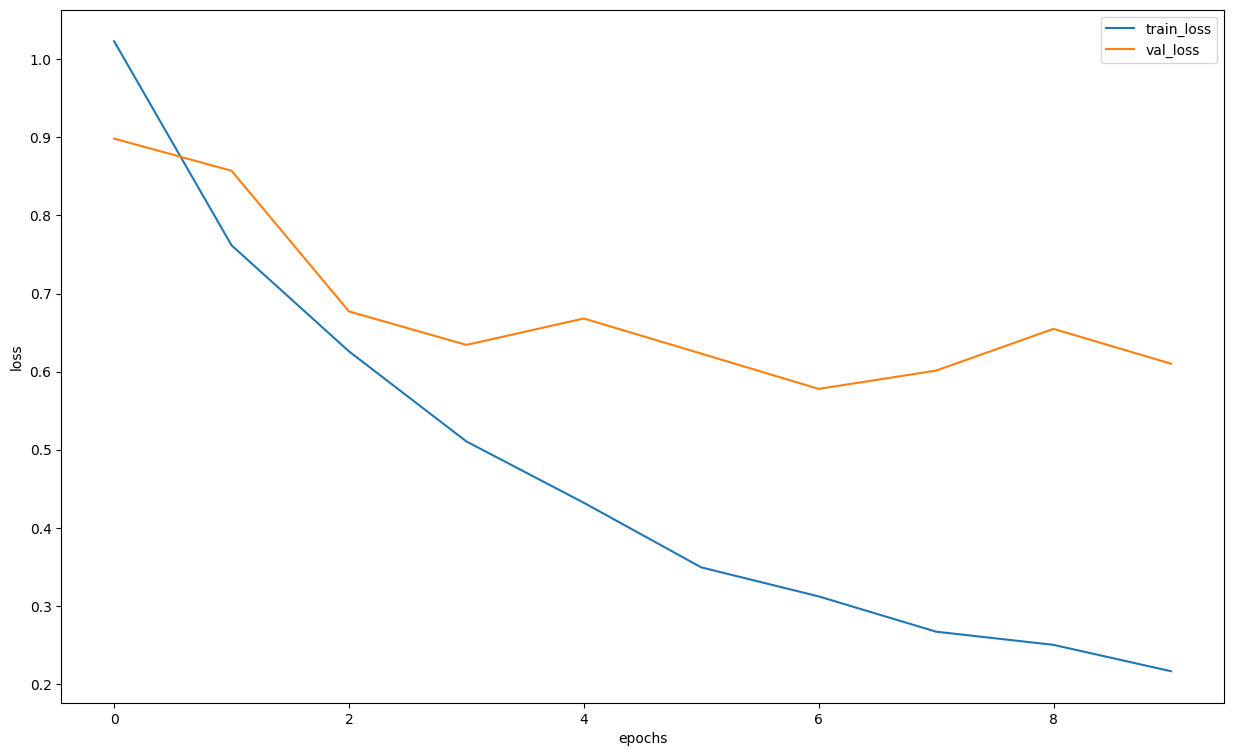

In [51]:


plt.figure(figsize=(15, 9))

plt.plot(loss, label="train_loss")

plt.plot(val_loss, label="val_loss")

plt.legend(loc='best')

plt.xlabel("epochs")

plt.ylabel("loss")

plt.show()

In [54]:
random_characters = int(np.random.uniform(0,1000))

ex_img, true_label = val_dataset[random_characters]

probs_im = predict_one_sample(my_not_simple_cnn, ex_img.unsqueeze(0))



idxs = np.arange(1000)

imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(my_not_simple_cnn, imgs)



label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))



y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]



from sklearn.metrics import f1_score

f1 = f1_score(actual_labels, y_pred, average='micro')



print("F1-оценка:", f1)



test_dataset = SimpsonsDataset(test_files, mode="test")

test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)

probs = predict(my_not_simple_cnn, test_loader)





preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))

test_filenames = [path.name for path in test_dataset.files]





import pandas as pd

my_submit = pd.read_csv("/kaggle/input/journey-springfield/sample_submission.csv")

my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})

# my_submit["Expected"] = preds

my_submit.head()

F1-оценка: 0.842


,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon




ну как видим, добавление нормализации, увеличения числа эпох и смена оптимизатора уже нам помогла

Теперь попробуем дообучить Resnet

In [ ]:
# 0.795 - 4 эпохи, батчнормы на всех кроме последнего
# 0.763 - 4 эпохи, батчнормы на всех кроме последнего, на 2х последних дропауты
#  - если переместить batchnorm до relu

In [ ]:
my_submit.to_csv('my_not_simple_cnn_baseline.csv', index=False)

In [55]:


from torchvision import models, transforms

from torch.utils.data import DataLoader, Dataset
from torchvision.models import vgg19

In [56]:
resnet = models.resnet18(pretrained=True)
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, n_classes)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 192MB/s]


In [57]:


train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))

test_files = sorted(list(TEST_DIR.rglob('*.jpg')))



from sklearn.model_selection import train_test_split



train_val_labels = [path.parent.name for path in train_val_files]

train_files, val_files = train_test_split(train_val_files, test_size=0.25, \

                                          stratify=train_val_labels)

val_dataset = SimpsonsDataset(val_files, mode='val')



n_classes = len(np.unique(train_val_labels))

resnet_simple_cnn = resnet.to(DEVICE)

print("we will classify :{}".format(n_classes))

print(resnet_simple_cnn)

we will classify :42
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): 

In [58]:
if val_dataset is None:

    val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(train_files, mode='train')

history = train_with_opt(train_dataset, val_dataset, model=resnet_simple_cnn, epochs=10, batch_size=64)

loss, acc, val_loss, val_acc = zip(*history)


epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 0.8380349839319886


epoch:  10%|█         | 1/10 [02:47<25:05, 167.26s/it]


Epoch 001 train_loss: 0.8380 val_loss 0.2980 train_acc 0.8206 val_acc 0.9335
loss 0.13982110263375053


epoch:  20%|██        | 2/10 [05:37<22:30, 168.77s/it]


Epoch 002 train_loss: 0.1398 val_loss 0.1894 train_acc 0.9737 val_acc 0.9570
loss 0.036267857475374615


epoch:  30%|███       | 3/10 [08:30<19:55, 170.73s/it]


Epoch 003 train_loss: 0.0363 val_loss 0.1398 train_acc 0.9955 val_acc 0.9671
loss 0.01195780682569192


epoch:  40%|████      | 4/10 [11:20<17:03, 170.64s/it]


Epoch 004 train_loss: 0.0120 val_loss 0.1249 train_acc 0.9992 val_acc 0.9723
loss 0.005689659447243877


epoch:  50%|█████     | 5/10 [14:13<14:16, 171.27s/it]


Epoch 005 train_loss: 0.0057 val_loss 0.1219 train_acc 0.9999 val_acc 0.9715
loss 0.0033216916424645207


epoch:  60%|██████    | 6/10 [17:04<11:24, 171.17s/it]


Epoch 006 train_loss: 0.0033 val_loss 0.1162 train_acc 0.9999 val_acc 0.9736
loss 0.002382901469495899


epoch:  70%|███████   | 7/10 [19:50<08:29, 169.70s/it]


Epoch 007 train_loss: 0.0024 val_loss 0.1166 train_acc 0.9999 val_acc 0.9729
loss 0.001687751281718189


epoch:  80%|████████  | 8/10 [22:37<05:37, 168.82s/it]


Epoch 008 train_loss: 0.0017 val_loss 0.1157 train_acc 0.9999 val_acc 0.9738
loss 0.0013335794978379099


epoch:  90%|█████████ | 9/10 [25:24<02:48, 168.08s/it]


Epoch 009 train_loss: 0.0013 val_loss 0.1170 train_acc 0.9999 val_acc 0.9738
loss 0.0011545759092264636


epoch: 100%|██████████| 10/10 [28:11<00:00, 169.17s/it]


Epoch 010 train_loss: 0.0012 val_loss 0.1150 train_acc 0.9999 val_acc 0.9734


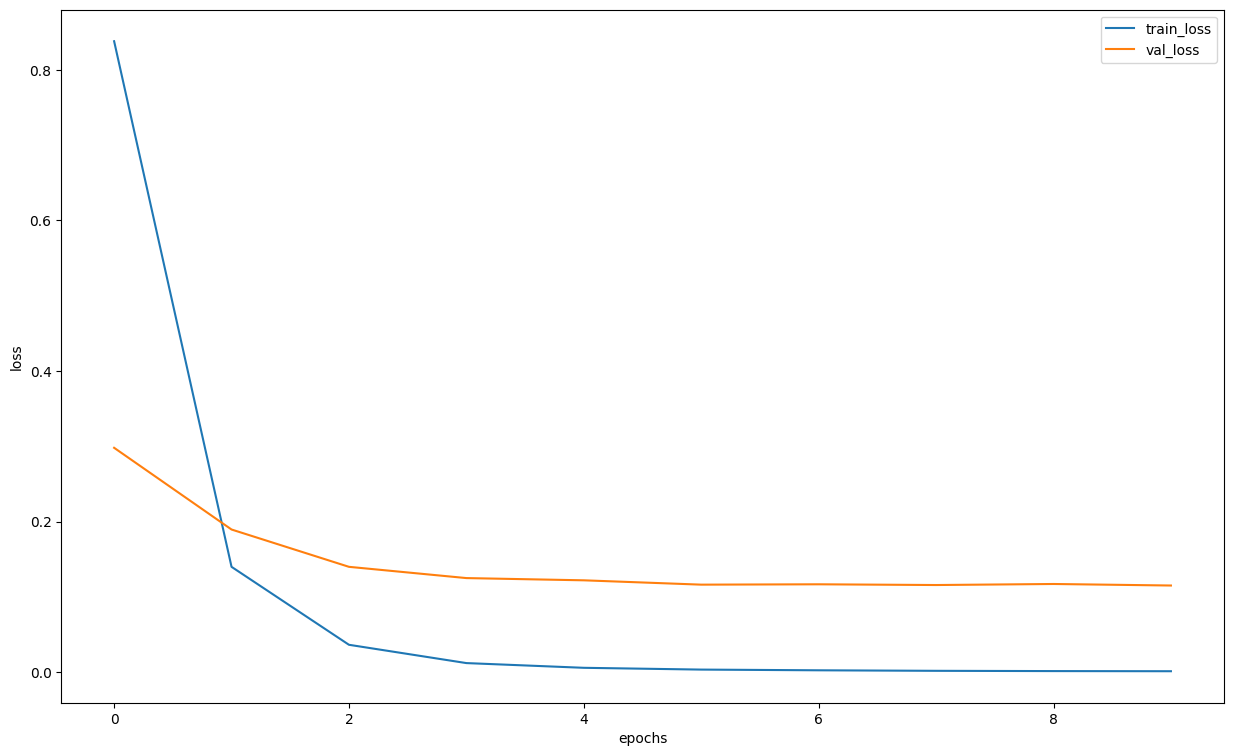

In [59]:


plt.figure(figsize=(15, 9))

plt.plot(loss, label="train_loss")

plt.plot(val_loss, label="val_loss")

plt.legend(loc='best')

plt.xlabel("epochs")

plt.ylabel("loss")

plt.show()

In [61]:
random_characters = int(np.random.uniform(0,1000))

ex_img, true_label = val_dataset[random_characters]

probs_im = predict_one_sample(resnet_simple_cnn, ex_img.unsqueeze(0))



idxs = list(map(int, np.random.uniform(0,1000, 20)))

imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(resnet_simple_cnn, imgs)



label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))



y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]



from sklearn.metrics import f1_score

f1 = f1_score(actual_labels, y_pred, average='micro')



print("F1-оценка:", f1)



test_dataset = SimpsonsDataset(test_files, mode="test")

test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)

probs = predict(resnet_simple_cnn, test_loader)





preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))

test_filenames = [path.name for path in test_dataset.files]





import pandas as pd

my_submit = pd.read_csv("/kaggle/input/journey-springfield/sample_submission.csv")

my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})

# my_submit["Expected"] = preds

my_submit.head()

F1-оценка: 1.0


,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [62]:
my_submit.to_csv('resnet18.csv', index=False)

In [64]:
resnet = models.resnet50(pretrained=True)
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, n_classes)


train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))

test_files = sorted(list(TEST_DIR.rglob('*.jpg')))



from sklearn.model_selection import train_test_split



train_val_labels = [path.parent.name for path in train_val_files]

train_files, val_files = train_test_split(train_val_files, test_size=0.25, \

                                          stratify=train_val_labels)

val_dataset = SimpsonsDataset(val_files, mode='val')



n_classes = len(np.unique(train_val_labels))

resnet_simple_cnn = resnet.to(DEVICE)

print("we will classify :{}".format(n_classes))

print(resnet_simple_cnn)
if val_dataset is None:

    val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(train_files, mode='train')

history = train_with_opt(train_dataset, val_dataset, model=resnet_simple_cnn, epochs=10, batch_size=64)

loss, acc, val_loss, val_acc = zip(*history)


we will classify :42
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_siz

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 0.6988549810238679


epoch:  10%|█         | 1/10 [05:01<45:11, 301.23s/it]


Epoch 001 train_loss: 0.6989 val_loss 0.2188 train_acc 0.8515 val_acc 0.9499
loss 0.1119350686308543


epoch:  20%|██        | 2/10 [10:05<40:23, 302.92s/it]


Epoch 002 train_loss: 0.1119 val_loss 0.1456 train_acc 0.9748 val_acc 0.9669
loss 0.044046084910462226


epoch:  30%|███       | 3/10 [15:12<35:34, 304.90s/it]


Epoch 003 train_loss: 0.0440 val_loss 0.1448 train_acc 0.9910 val_acc 0.9660
loss 0.032578401578859245


epoch:  40%|████      | 4/10 [20:15<30:24, 304.11s/it]


Epoch 004 train_loss: 0.0326 val_loss 0.1269 train_acc 0.9934 val_acc 0.9683
loss 0.019528222958168084


epoch:  50%|█████     | 5/10 [25:18<25:19, 303.87s/it]


Epoch 005 train_loss: 0.0195 val_loss 0.1989 train_acc 0.9957 val_acc 0.9553
loss 0.018392029144280397


epoch:  60%|██████    | 6/10 [30:21<20:13, 303.44s/it]


Epoch 006 train_loss: 0.0184 val_loss 0.1675 train_acc 0.9955 val_acc 0.9601
loss 0.031522732258770364


epoch:  70%|███████   | 7/10 [35:24<15:10, 303.38s/it]


Epoch 007 train_loss: 0.0315 val_loss 0.1692 train_acc 0.9918 val_acc 0.9614
loss 0.01987789417565708


epoch:  80%|████████  | 8/10 [40:28<10:06, 303.36s/it]


Epoch 008 train_loss: 0.0199 val_loss 0.1734 train_acc 0.9953 val_acc 0.9597
loss 0.017323599552378676


epoch:  90%|█████████ | 9/10 [45:30<05:03, 303.21s/it]


Epoch 009 train_loss: 0.0173 val_loss 0.1329 train_acc 0.9956 val_acc 0.9696
loss 0.02188615535216063


epoch: 100%|██████████| 10/10 [50:35<00:00, 303.51s/it]


Epoch 010 train_loss: 0.0219 val_loss 0.1476 train_acc 0.9947 val_acc 0.9658


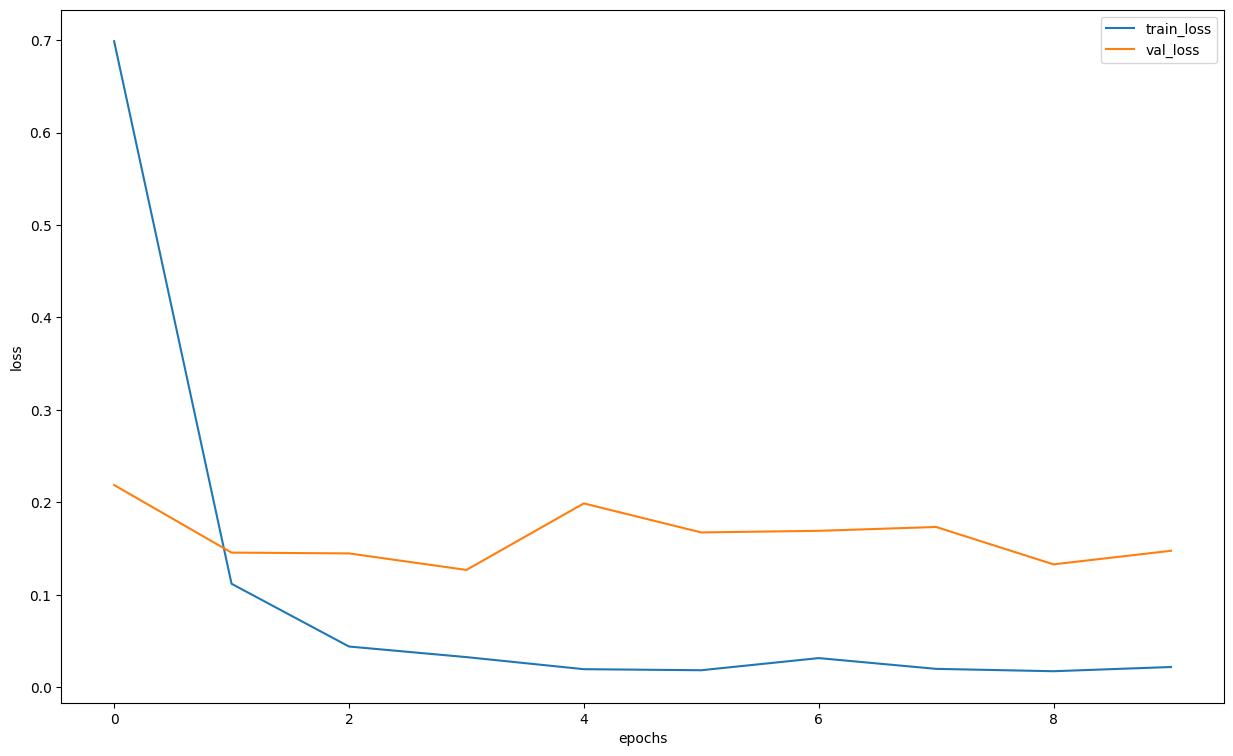

In [65]:


plt.figure(figsize=(15, 9))

plt.plot(loss, label="train_loss")

plt.plot(val_loss, label="val_loss")

plt.legend(loc='best')

plt.xlabel("epochs")

plt.ylabel("loss")

plt.show()

In [66]:
random_characters = int(np.random.uniform(0,1000))

ex_img, true_label = val_dataset[random_characters]

probs_im = predict_one_sample(resnet_simple_cnn, ex_img.unsqueeze(0))



idxs = list(map(int, np.random.uniform(0,1000, 20)))

imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(resnet_simple_cnn, imgs)



label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))



y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]



from sklearn.metrics import f1_score

f1 = f1_score(actual_labels, y_pred, average='micro')



print("F1-оценка:", f1)



test_dataset = SimpsonsDataset(test_files, mode="test")

test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)

probs = predict(resnet_simple_cnn, test_loader)





preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))

test_filenames = [path.name for path in test_dataset.files]





import pandas as pd

my_submit = pd.read_csv("/kaggle/input/journey-springfield/sample_submission.csv")

my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})

# my_submit["Expected"] = preds

my_submit.head()
my_submit.to_csv('resnet50.csv', index=False)

F1-оценка: 0.9500000000000001


видим, что Resnet18 получше чем resnet50 

In [ ]:
Анна_Мацкевич_421676042. Итоговая оценка на кагле 0.99...